# Fit n-PDF of nickel and diffractometer zero

In this example we refine constant wavelength neutron PDF data from nickel powder collected at the PEARL instrument at the TU Delft, Netherlands.  The optimum experimental PDF is obtained with a slight correction of the diffractometer zero, which accounts for a slight sample off-centering.  The zero correction affects the observed PDF which is fitted with a PDF simulation from nickel.  Here we use the DiffPy-CMI to fit both the nickel structure parameters and diffractometer zero.

## Initialization

We start with some necessary imports from diffpy packages and define a convenience function for plotting the PDF fit.  It is safe to skip to the [next section](#Configuration).

In [1]:
# plotting
%matplotlib notebook
import matplotlib
matplotlib.rc('figure', figsize=(5, 3.75))
from matplotlib.pyplot import subplots

import copy
import numpy as np

# pdfgetx3 functions to convert PDF on the fly
from diffpy.pdfgetx import PDFGetter, PDFConfig, loadData

# srfit functions to setup nickel PDF refinement
from diffpy.srfit.fitbase import FitRecipe, FitResults
from diffpy.srfit.pdf import PDFContribution
from diffpy.srfit.structure import constrainAsSpaceGroup
from diffpy.Structure import loadStructure
# scipy LM optimizer
from scipy.optimize import leastsq

In [2]:
def plotmyfit(recipe, baseline=-4, ax=None):
    """
    Show nice PDF refinement plot.

    Plot observed data, simulation and the difference curve offset
    to baseline.

    Return matplotlib Line objects.
    """
    from matplotlib import pyplot
    if ax is None:
        ax = pyplot.gca()
    x = recipe.cpdf.profile.x
    yobs = recipe.cpdf.profile.y
    ycalc = recipe.cpdf.evaluate()
    ydiff = yobs - ycalc
    rv = []
    rv += ax.plot(x, yobs, 'o', label='Gobs',
                    markeredgecolor='blue', markerfacecolor='none')
    rv += ax.plot(x, ycalc, color='red', label='Gcalc')
    rv += ax.plot(x, ydiff + baseline, label='Gdiff', color='green')
    rv += ax.plot(x, baseline + 0 * x, linestyle=':', color='black')
    ax.set_xlabel(u'r (Å)')
    ax.set_ylabel(u'G (Å$^{-2}$)')
    return rv

## Configuration

First we define some global constant to specify the PDF fit range, CIF structure model and the text file with powder diffraction data.

In [3]:
# global constants
myfitrange = (1, 20)
myrstep = 0.01
myciffile = "Ni-9008476.cif"
mypowderdata = 'ni_755tthM.dat'

Next we use functions from the `diffpy.pdfgetx` package to create PDF-conversion object `pg0`.  We use it for initial PDF extraction without zero correction and store the results as `r0`, `g0`.

In [4]:
cfg = PDFConfig(mode='neutron',
                composition='Ni',
                wavelength=1.0989,
                dataformat='twotheta',
                rstep=myrstep, rmin=myfitrange[0], rmax=myfitrange[1])
cfg.qmax = cfg.qmaxinst = 11.2
pg0 = PDFGetter(config=cfg)
r0, g0 = pg0(filename=mypowderdata)

We also define a convenience function `new_nickel_refinement` which creates srfit `FitRecipe` object for PDF refinement of nickel structure.  The resulting fit recipe will be adjusted for zero-refinement later.

In [5]:
def new_nickel_refinement():
    """Create FitRecipoe for nickel NPDF refinement.
    """
    # setup fit contribution for nickel NPDF
    cpdf = PDFContribution('cpdf')
    # specify we model neutron PDF at qmax from the configuration file.
    # also set the initial observed data to the initial PDF.
    cpdf.setScatteringType('N')
    cpdf.setQmax(cfg.qmax)
    cpdf.profile.setObservedProfile(r0.copy(), g0.copy())
    # specify independent nickel structure model and apply symmetry constraints.
    cpdf.addStructure('ni', loadStructure(myciffile))
    sgpar = constrainAsSpaceGroup(cpdf.ni.phase, 'F m -3 m')
    # create FitRecipe to manage the refinement
    nfit = FitRecipe()
    nfit.addContribution(cpdf)
    nfit.addVar(cpdf.scale)
    nfit.addVar(cpdf.qdamp, value=0.03)
    nfit.addVar(cpdf.qbroad, value=0.0, fixed=True)
    nfit.addVar(sgpar.latpars.a)
    nfit.addVar(sgpar.adppars.Uiso_0, name='uiso', value=0.004)
    nfit.addVar(cpdf.ni.delta2, value=3.0)
    # silence diagnostic output.
    nfit.clearFitHooks()
    # override internal calculator step
    return nfit

## Fit nickel to initial PDF (no zero correction)

<IPython.core.display.Javascript object>


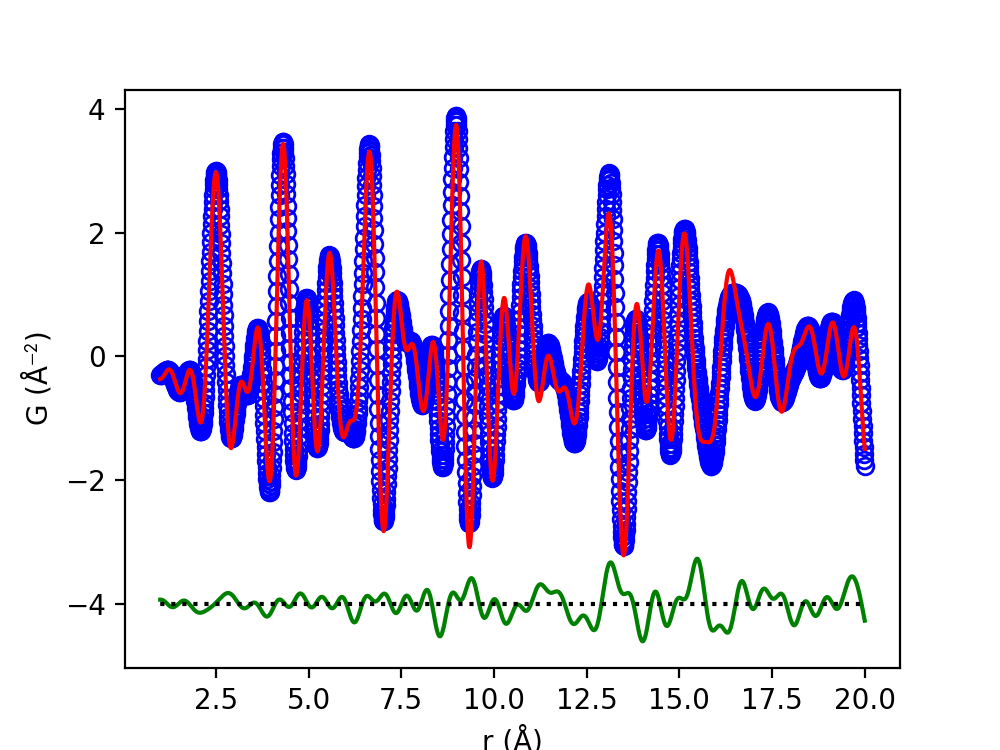

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       94.43444524
Contributions  94.43444524
Restraints     0.00000000
Chi2           94.43444524
Reduced Chi2   0.04980720
Rw             0.18300906

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
a       3.52883975e+00 +/- 8.92290203e-04
delta2  1.51797577e+00 +/- 2.01821920e+00
qdamp   4.13514349e-02 +/- 6.33516914e-03
scale   2.37591235e-01 +/- 1.13859715e-02
uiso    3.98272111e-03 +/- 5.51846562e-04

Fixed Variables
------------------------------------------------------------------------------
qbroad  0.00000000e+00

Variable Correlations greater than 25% (Correlations invalid)
------------------------------------------------------------------------------
corr(scale, qdamp)    0.6480
corr(scale, uiso)     0.5536
corr(qdamp, delta2) 

In [6]:
nifit0 = new_nickel_refinement()
leastsq(nifit0.residual, nifit0.values)
nires0 = FitResults(nifit0)

fig0, ax0 = subplots();
plotmyfit(nifit0, ax=ax0)
print(nires0)

**Outcome**

The PDF fit of non-corrected data shows fair agreement, but notable differences over 10 Å and an elevated Rw = 0.18.

## Fit nickel PDF and diffractometer zero

We first define a new PDF-conversion object `pg1` to make it separate from initial conversion.  Next we define a helper function `gfixzero` to compute PDF when the actual zero angle is at `zero` in diffractometer units.

In [7]:
pg1 = pg0.copy()
def gfixzero(zero):
    r, g = pg1(twothetazero=zero)
    return g

# add sanity check
assert np.array_equal(g0, gfixzero(0))

Next we create a separate fit recipe for a new refinement.  We change it to tie the observed PDF to the `gfixzero` result at a refinable `zero` argument.

In [8]:
nifit1 = new_nickel_refinement()
nifit1.newVar('zero', value=0)
nifit1.registerFunction(gfixzero, name='gfixzero')
nifit1.constrain(nifit1.cpdf.y, 'gfixzero')

Now we run least squares fit with the new recipe and refine also the `zero` offset in addition to structure variables.

<IPython.core.display.Javascript object>


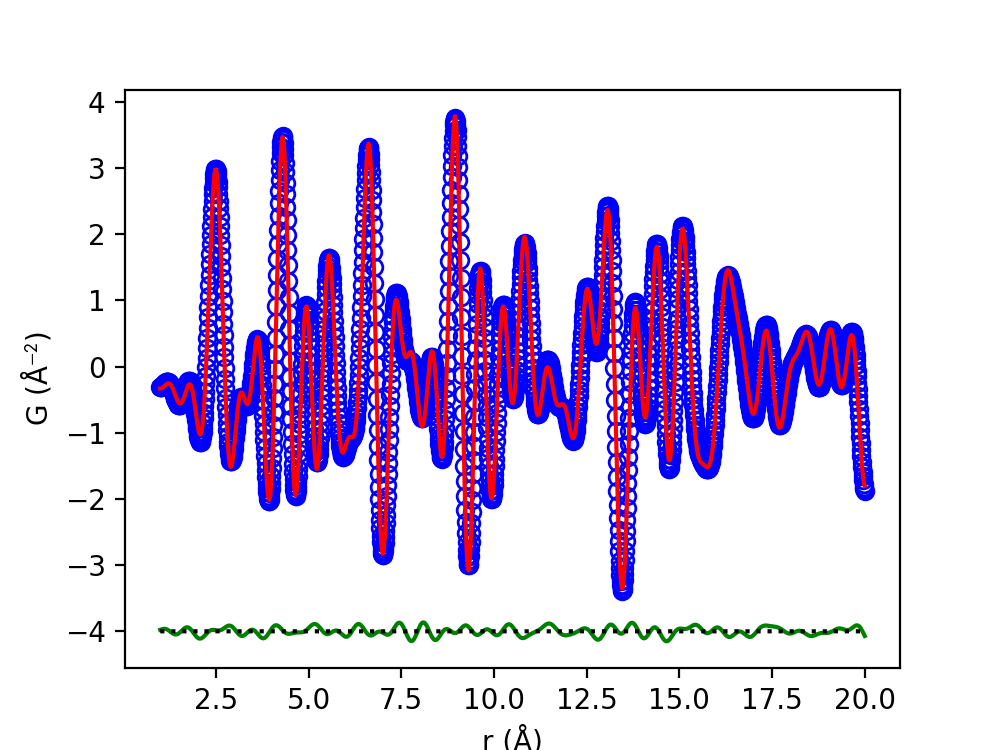

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       6.98487268
Contributions  6.98487268
Restraints     0.00000000
Chi2           6.98487268
Reduced Chi2   0.00368595
Rw             0.04956228

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
a       3.51861185e+00 +/- 1.42519701e-03
delta2  1.42074502e+00 +/- 1.86036673e+00
qdamp   3.58694224e-02 +/- 6.80088009e-03
scale   2.40363334e-01 +/- 1.12413108e-02
uiso    4.31031445e-03 +/- 5.40426791e-04
zero    -3.73763834e-01 +/- 3.52450368e-02

Fixed Variables
------------------------------------------------------------------------------
qbroad  0.00000000e+00

Variable Correlations greater than 25% (Correlations invalid)
------------------------------------------------------------------------------
corr(a, zero)         0.7889
corr(scal

In [9]:
leastsq(nifit1.residual, nifit1.values)
nires1 = FitResults(nifit1)

fig1, ax1 = subplots();
plotmyfit(nifit1, ax=ax1)
print(nires1)

**Outcome**

With a refined diffractometer zero the PDF fit shows excellent agreement with a very low Rw = 0.05.  The zero offset refined to -0.37 degrees.

In [10]:
# export the results
def myexport():
    "Convenience function to save nickel fit results."
    nifit0.cpdf.profile.savetxt('nifit0.dat', fmt='%g')
    nires0.saveResults('nifit0.res')
    nifit1.cpdf.profile.savetxt('nifit1.dat', fmt='%g')
    nires1.saveResults('nifit1.res')
    return

## uncomment the line below to export fit results
#myexport()